In [1]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
d = np.load("../data/training_data/splits.npz", allow_pickle=True)
X_train = d["X_train"]
X_test = d["X_test"]
y_train = d["y_train"]
y_test = d["y_test"]

In [3]:
d = np.load("../data/training_data/features_labels.npz", allow_pickle=True)
X = d["X"]
y = d["y"]

In [4]:
# Start with default parameters
cat = CatBoostClassifier(
    random_state=42,
    verbose=False, 
    thread_count=-1  # Use all available cores
)

# Train the model
start_time = time.time()
cat.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_basic = cat.predict(X_test)

# Evaluate
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print("CatBoost Results:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Training time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_basic))

CatBoost Results:
Accuracy: 0.9762
Training time: 1.51 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.99      0.96      0.97       379
           2       0.96      0.97      0.96       397
           3       0.96      0.97      0.97       399

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



Top 10 Most Important Features:
       feature  importance
7    Feature_7    9.215015
10  Feature_10    8.815719
11  Feature_11    7.610192
15  Feature_15    7.432071
5    Feature_5    6.848254
4    Feature_4    6.502580
6    Feature_6    6.281440
0    Feature_0    6.079506
3    Feature_3    5.810313
8    Feature_8    5.646757


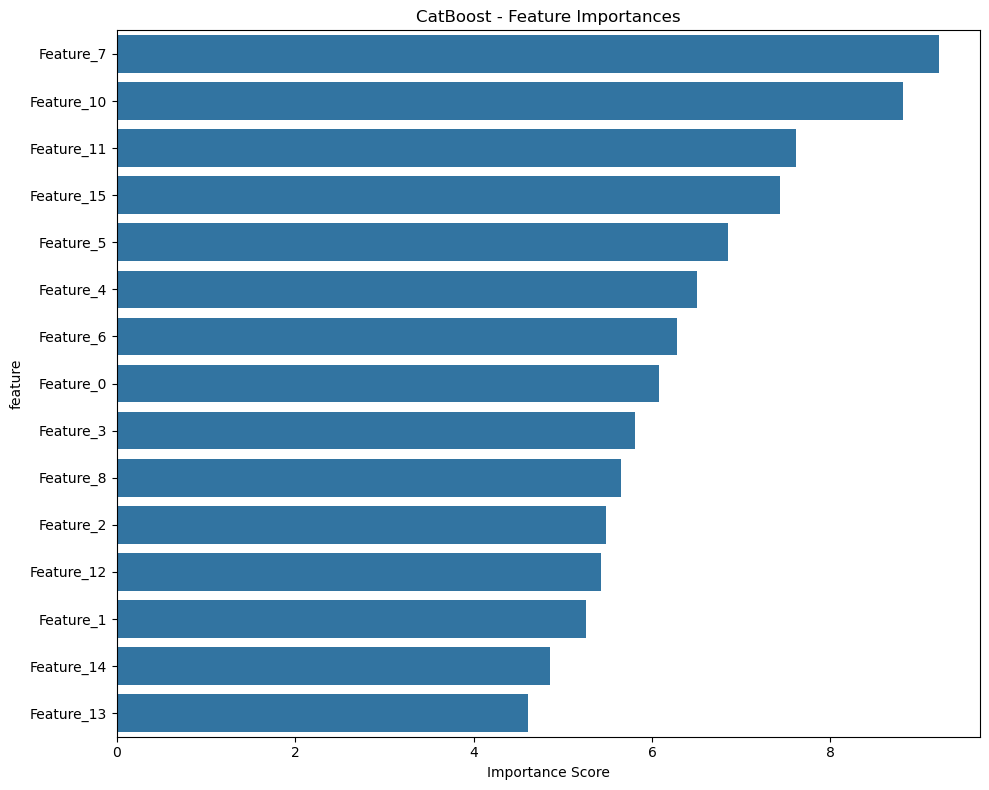

In [5]:
# Get feature importances
feature_importances = cat.get_feature_importance()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature')
plt.title('CatBoost - Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()
plt.show()

In [6]:
# Define parameter distribution for RandomizedSearch
param_dist = {
    'iterations': [100, 200, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128, 256],
    'random_strength': [0, 0.5, 1, 2]
}

print("Starting Randomized Search for CatBoost...")
start_time = time.time()

# Perform randomized search
random_search = RandomizedSearchCV(
    CatBoostClassifier(random_state=42, verbose=False, thread_count=-1),
    param_distributions=param_dist,
    n_iter=25,  # Number of parameter combinations to try
    cv=3,       # 3-fold CV
    scoring='accuracy',
    n_jobs=-1,  # Note: CatBoost uses thread_count, but we set n_jobs for CV
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Randomized search completed in {time.time() - start_time:.2f} seconds")

# Best parameters and score
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

Starting Randomized Search for CatBoost...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Randomized search completed in 86.00 seconds

Best parameters found:
  random_strength: 2
  learning_rate: 0.2
  l2_leaf_reg: 1
  iterations: 200
  depth: 10
  border_count: 64
Best cross-validation score: 0.9609


In [7]:
# Use best parameters from randomized search to inform grid search
print("\nStarting Grid Search for Fine-Tuning...")

# Get best parameters from randomized search
best_params = random_search.best_params_

# Create focused grid around best parameters
param_grid = {
    'iterations': [
        max(50, best_params['iterations'] - 50),
        best_params['iterations'],
        best_params['iterations'] + 50
    ],
    'depth': [
        max(4, best_params['depth'] - 2),
        best_params['depth'],
        min(10, best_params['depth'] + 2)
    ],
    'learning_rate': [
        max(0.01, best_params['learning_rate'] - 0.05),
        best_params['learning_rate'],
        min(0.3, best_params['learning_rate'] + 0.05)
    ],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    CatBoostClassifier(random_state=42, verbose=False, thread_count=-1),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters from Grid Search:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Starting Grid Search for Fine-Tuning...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters from Grid Search:
  depth: 10
  iterations: 250
  l2_leaf_reg: 1
  learning_rate: 0.2
Best cross-validation score: 0.9647


In [8]:
# Use the best model from grid search
final_cat = grid_search.best_estimator_

# Make final predictions
y_pred_final = final_cat.predict(X_test)
y_pred_proba = final_cat.predict_proba(X_test)  # Probability scores

# Comprehensive evaluation
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal CatBoost Model Performance:")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))


Final CatBoost Model Performance:
Test Accuracy: 0.9756
Best Parameters: {'depth': 10, 'iterations': 250, 'l2_leaf_reg': 1, 'learning_rate': 0.2}

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.99      0.96      0.97       379
           2       0.94      0.97      0.96       397
           3       0.97      0.97      0.97       399

    accuracy                           0.98      1600
   macro avg       0.98      0.97      0.98      1600
weighted avg       0.98      0.98      0.98      1600



In [9]:
# CatBoost has its own efficient cross-validation implementation
def catboost_cross_validation(X_train, y_train, params):
    """
    Use CatBoost's built-in cross-validation
    """
    print("Running CatBoost Built-in Cross-Validation...")

    # Create Pool for CatBoost
    train_pool = Pool(X_train, y_train)

    # Run cross-validation
    cv_results = cv(    
        pool=train_pool,
        params=params,
        fold_count=5,  # 5-fold CV
        stratified=True,
        partition_random_seed=42,
        verbose=False,
        plot=True  # This will plot the learning curves
    )

    # Get best accuracy
    best_accuracy = cv_results['test-Accuracy-mean'].max()
    best_iteration = cv_results['test-Accuracy-mean'].idxmax()

    print(f"Best CV Accuracy: {best_accuracy:.4f} at iteration {best_iteration}")

    return cv_results, best_accuracy

# Use best parameters for CV
cv_params = grid_search.best_params_.copy()
cv_params['eval_metric'] = 'Accuracy'
cv_params.update({
    'loss_function': 'MultiClass',
    'random_state': 42,
    'verbose': False
})

# Run CatBoost CV
cv_results, best_cv_accuracy = catboost_cross_validation(X_train, y_train, cv_params)

Running CatBoost Built-in Cross-Validation...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.972698908
bestIteration = 173

Training on fold [1/5]

bestTest = 0.9703125
bestIteration = 223

Training on fold [2/5]

bestTest = 0.98203125
bestIteration = 177

Training on fold [3/5]

bestTest = 0.9734167318
bestIteration = 159

Training on fold [4/5]

bestTest = 0.9741985927
bestIteration = 229

Best CV Accuracy: 0.9741 at iteration 231


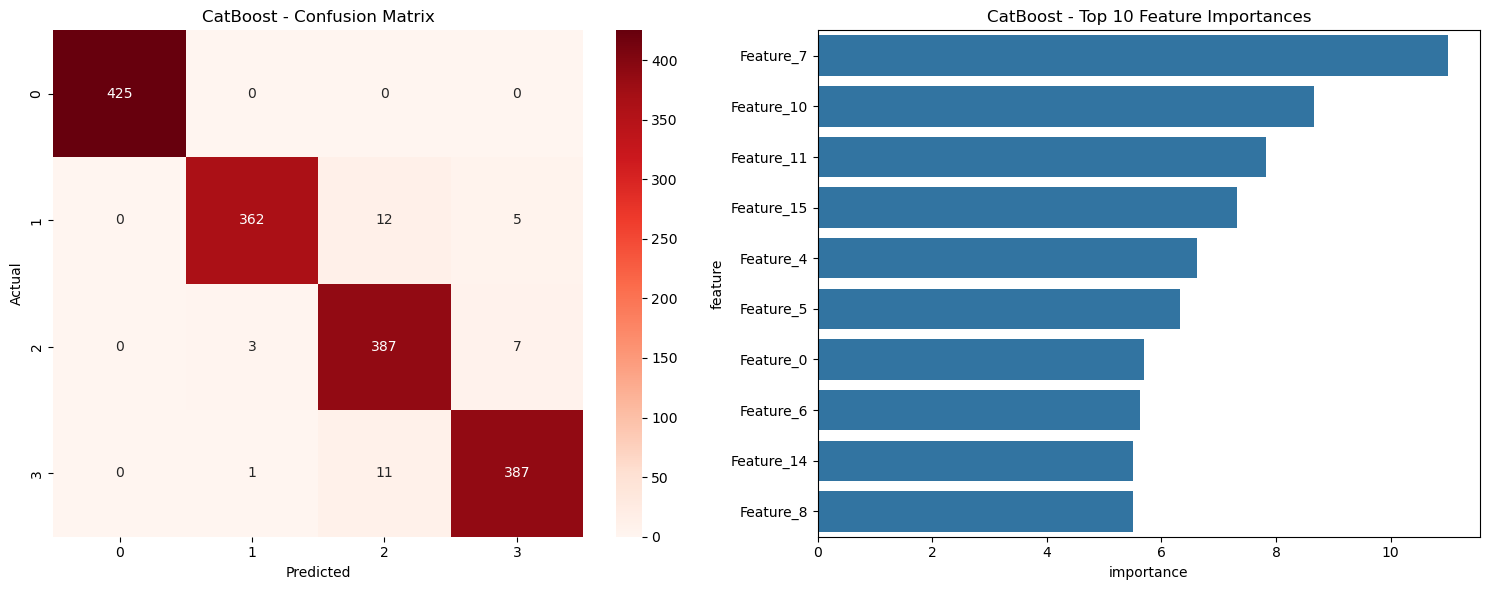

Learning curve plotting not available in this version


<Figure size 1000x600 with 0 Axes>

In [10]:
# Confusion Matrix and Feature Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax1)
ax1.set_title('CatBoost - Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Feature Importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'importance': final_cat.get_feature_importance()
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', ax=ax2)
ax2.set_title('CatBoost - Top 10 Feature Importances')

plt.tight_layout()
plt.show()

# Learning curves (if available)
try:
    plt.figure(figsize=(10, 6))
    final_cat.plot_learning_curve()
    plt.title('CatBoost Learning Curves')
    plt.show()
except:
    print("Learning curve plotting not available in this version")

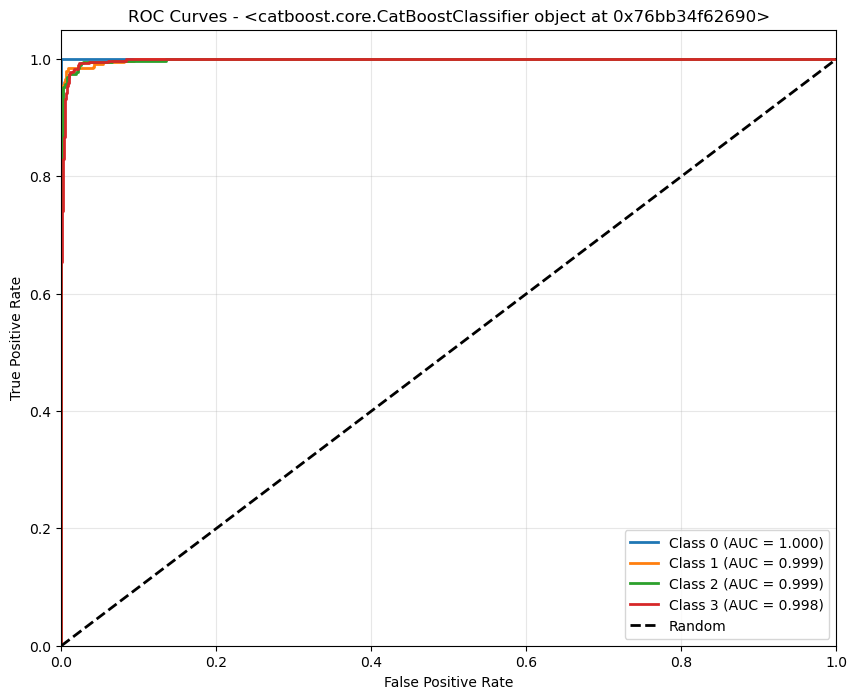

In [11]:
# Get predictions for all classes
y_pred_proba = final_cat.predict_proba(X_test)

# Binarize the labels (convert to one-hot encoding)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Calculate ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

# Add random classifier line and format
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {final_cat}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Save the classification report
report_dict = classification_report(y_test, y_pred_final, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
df.to_csv("performance_metrics/classification_reports/catboost_report.csv") 

In [13]:
# Save the trained model
final_cat.save_model('trained_models/catboost_model.cbm')
print("Catboost model saved")

Catboost model saved
